In [1]:
import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In this module, we show the entire pipeline to estimate the solar power production according to the user's location, roof area and monthly electricity bill. <br>
In doing so, we make use of the results developed in the different modules of the project. <br>
These are basically the same steps executed by the website when it is queried.

# Nearest Stations

Firstly, we import the libraries of the `geocoding module` in order get the _k_ closest stations to the user's location.

In [2]:
cd geocoding/

/home/ema/Dropbox/ada/solarity/geocoding


In [3]:
import geocoding_functions as geo_fns
import location_functions as loc_fns
import station_info

## Parameters

We will consider the power production of a given address as being affected by its _k = 4_ cloest weather stations, proportionally to their relative distances.

In [4]:
k = 4 # Number of nearest neighbouring stations

## User input

In [5]:
address = "Rämistrasse 101, 8092 Zürich"

### Get coordinates of the address

In [6]:
coordinates = geo_fns.getCoordinates(address)
if(coordinates is None):
    print("*** Invalid Address ***")
    print("Sample address: Route Cantonale 33, 1025 St. Sulpice")
    exit(0)

In [7]:
coordinates

(47.3765359, 8.5480928)

## Import weather stations

We load the location of each weather station, stored in a pickle file.

In [8]:
station_df = pickle.load(open("station_df.p","rb"))

In [9]:
len(station_df)

143

There is a total of 143 stations from MeteoSwiss.

In [10]:
station_df.head()

,name,lat,lng
0,NAP,47.000000,7.933333
1,TAE,47.483333,8.900000
2,MTE,46.150000,7.616667
3,WSLNAF,46.666667,10.233333
4,UEB,47.350000,8.483333


## Retrieve k nearest stations and their weights

We now get which stations are the closest to the user's address and how much measurements in each of them influence the weather at the user's address.

In [11]:
neighbourNames = loc_fns.get_k_nearest_neighbours(coordinates, k, station_df)
neighbourWeights = loc_fns.get_weights_for_k_nearest(coordinates, k, station_df)

In [12]:
neighbourNames

96    SMA
4     UEB
36    REH
47    KLO
Name: name, dtype: object

In [13]:
neighbourWeights

array([ 0.6068449 ,  0.16922659,  0.14304639,  0.08088212])

# Solar potential

The solar potential of each stations has been precomputed. Now, we load it and extract the potential of the nearest stations. <br>
We use the extracted solar potentials and weights of the stations to compute the net solar potential of the given address.

In [14]:
cd ..

/home/ema/Dropbox/ada/solarity


In [15]:
means = pickle.load(open('learning/groupedStations.p', 'rb'))

In [16]:
def get_average_power_potential(stations, weights, means):
    """
    Retrieve monthly average power potential for home according to weighted sum of potentials from closest stations.
    :param stations: a pd.DataFrame with columns=[name, lat, lng]
    :param weights: a sorted np.Array of distance weights associated to the k closest stations to house
    :param means: a pd.DataFrame of average montly potential for each station
    :return: monthly average power potential for home address
    """
    potential = 0
    for i in range(len(stations)):
        potential += np.sum(means.power[stations[i]].get_values()) * \
                     weights[i] / len(means.power[stations[i]].get_values())
    
    return potential

In [17]:
monthly_potential = get_average_power_potential(neighbourNames.get_values(), neighbourWeights, means)

In [18]:
potentialAllFeatures = np.mean(np.array(monthly_potential)) # Wp
potentialAllFeatures

0.13477425157321793

# Installation Costs

## User's input

To provide an estimation of the investment needed to go solar, we ask the user to provide her monthly average electricity bill and her roof area.

In [19]:
averageElectricityBill = np.array([80]) # CHF
roofArea = 120 # m2

## Parameters

### Electricity

We consider an average electricity tariff of 20 cents/kWh, as described in the `economicParameters module`.

In [20]:
elecTariff = 0.20 # CHF/kWh

### Solar

And we consider the following characteristics for the solar panel according to the information we have collected. Further details are also available in the `economicParameters module`.

In [21]:
capacityPerPanel = 255 # Wp
costPerPanel = 500 # CHF
panelArea = 1.62 # m2

## Average Consumption

Given these parameters and the user's input, we can estimate the average power consumed by the user.

In [22]:
hours = 24
days = 30

In [23]:
avgEnergy = averageElectricityBill / elecTariff

In [24]:
avgPower = avgEnergy / (hours*days) # kW
avgPower

array([ 0.55555556])

## Solar Cost and Capacity

Users can choose to cover different percentages of their roof areas, according to the initial investment needed, the break-even time and the total savings. <br>
Here, we consider a step of 5% of coverage area between the different installations.

In [25]:
installation = np.array(range(5,101,5)) / 100

For each coverage area percentage, we can cumpute the maximum number of panels needed.

In [26]:
numPanels = np.floor(roofArea/panelArea)

And, from them, estimate the investment for the household, the power capacity of each of the installations and their solar potential.

In [27]:
capacity = installation * numPanels * capacityPerPanel / 1000 # kWp
cost = installation * numPanels * costPerPanel # CHF

In [28]:
solarPower = capacity * monthly_potential # kW

### Finding suitable installations

We assume that the startegy of the household is to breakeven. 
So, suitable installations of solar panels will be the ones where the solar capacity is less than the average power consumption of the household.

In [29]:
indx = solarPower <= avgPower

installationFinal = installation[indx]
installCapacity = capacity[indx]
installCost = cost[indx]
installPower = solarPower[indx]

In [30]:
solar_df = pd.DataFrame()
solar_df['capacity [kW]'] = installCapacity
solar_df['cost [CHF]'] = installCost
solar_df['power [kW]'] = installPower
solar_df['installation [%]'] = installationFinal
solar_df = solar_df.set_index('installation [%]')
solar_df

,capacity [kW],cost [CHF],power [kW]
installation [%],,,
0.05,0.9435,1850.0,0.127160
0.10,1.8870,3700.0,0.254319
0.15,2.8305,5550.0,0.381479
0.20,3.7740,7400.0,0.508638


# Savings and break-even time

Here, we compute the new electricity bill that he household would incur, after solar installations.

In [31]:
hoursInADay = 24
daysInAMonth = 30
def get_new_bill(bill, power, elec_tariff):
    """
    Compute monthly electricity bill when using installation giving passed solar power.
    :param bill: monthly electricity bill of user
    :param power: monthly solar power produced with a given installation
    :param elec_tariff: electricity tariff at user's house location
    :return: new monthly average electricity bill and new monthly usage pattern for the produced solar power
    """
    avgEnergyUsed = bill / elec_tariff
    avgEnergyUsed_daytime = avgEnergyUsed / 2
    nightUsage = avgEnergyUsed / 2

    avgEnergyProduced = power * hoursInADay * daysInAMonth
    
    newBill = np.empty(len(power))
    newUsageFromUtility = np.empty(len(power))
    for i in range(len(power)):
        dayUsage = max(0, avgEnergyUsed_daytime - avgEnergyProduced[i])
        newUsageFromUtility[i] = dayUsage + nightUsage
        newBill[i] = newUsageFromUtility[i] * elec_tariff

    return newBill, newUsageFromUtility

In [32]:
newBill, newUsage = get_new_bill(averageElectricityBill, installPower, elecTariff)

Here, savings are computed as: 
$$savings\_for\_an\_installation = new\_bill - old\_bill - cost\_of\_installation$$
$$$$
We compute the monthly savings for a period of 25 years.

In [33]:
totalYears = 25
monthsInAYear = 12
def get_cumulative_savings(oldBill, newBill, cost):
    """
    Compute savings over 25 years earned by going solar.
    :param oldBill: average monthly electricity bill of the user before installing solar panels
    :param newBill: monthly electricity bill when installing a given number of solar panels
    :param cost: initial investment for solar installation
    :return:
    """
    months = range(1, totalYears*monthsInAYear + 1)
    savings = np.empty((len(newBill), len(months)))
    for i in range(len(newBill)):
        eachMonth = oldBill - newBill[i]
        savings[i,:] = eachMonth * months - cost[i]
    return savings

In [34]:
savings = get_cumulative_savings(averageElectricityBill, newBill, installCost)
finalSavings = savings[:,-1]

From the monthly savings over a period of 25 years, we compute the break-even time.

In [35]:
def get_break_even_time(savings):
    """
    Compute number of years until payback for each possible installation plan.
    :param savings:
    :return: array of number of years until payback
    """
    nInstalls = savings.shape[0]
    breakEven = np.empty(nInstalls)
    for i in range(nInstalls):
        breakEven[i] = np.argmax(savings[i,:] > 0)

    return breakEven

In [36]:
breakEven = get_break_even_time(savings) / 12 # number of years until payback

# Results

Here, we summarize the characteristics for all the suitable installations.

In [37]:
final_df = solar_df
final_df['breakEvenYears'] = breakEven
final_df['savings_after_25yrs [CHF]'] = finalSavings
final_df['annual_savings [CHF]'] = finalSavings / totalYears
final_df

,capacity [kW],cost [CHF],power [kW],breakEvenYears,savings_after_25yrs [CHF],annual_savings [CHF]
installation [%],,,,,,
0.05,0.9435,1850.0,0.127160,8.416667,3643.290675,145.731627
0.10,1.8870,3700.0,0.254319,8.416667,7286.581349,291.463254
0.15,2.8305,5550.0,0.381479,11.500000,6450.000000,258.000000
0.20,3.7740,7400.0,0.508638,15.416667,4600.000000,184.000000


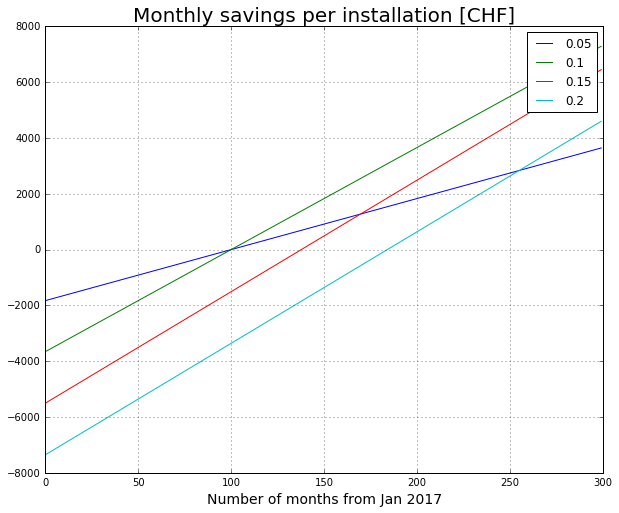

In [38]:
plt.figure(figsize=(10,8))
for i in range(savings.shape[0]):
    plt.plot(savings[i,:])
plt.xlabel('Number of months from Jan 2017', fontsize=14)
plt.title('Monthly savings per installation [CHF]', fontsize=20)
plt.legend(final_df.index.values)
plt.grid()